# scRNA-seq Analysis on 10x Genomic Dataset

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import rc_context
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import DistanceMetric
from sklearn.decomposition import PCA
from kneed import KneeLocator as kl

In [2]:
sc.set_figure_params(dpi=80, facecolor = 'white') #color_map = 'viridis_r')
sc.settings.verbosity = 3

## Download the Data

The dataset I will be downloading and using for this analysis comes from the article *Transcriptional Heterogeneity and Lineage Commitment in Myeloid Progenitors* by Paul et. al. <a href = "https://doi.org/10.1016/j.cell.2015.11.013"> (Cell) </a> This data will go undergo basic preprocessing and visualization of standard scRNA-seq workflow which inlcudes, quality control processing, data normalization, dimensionality reduction, and clustering. 

In [3]:
adata = sc.datasets.paul15()

... storing 'paul15_clusters' as categorical
Trying to set attribute `.uns` of view, copying.


In [4]:
adata.var_names_make_unique() 

In [5]:
# Take a look at our annotated data object
# adata is a cells x genes matirx 
# n_obs = number of cells
# n_vars = number of genes
print(adata)
adata.to_df().head()

AnnData object with n_obs × n_vars = 2730 × 3451
    obs: 'paul15_clusters'
    uns: 'iroot'


,0610007L01Rik,0610009O20Rik,0610010K14Rik,0910001L09Rik,1100001G20Rik,1110002B05Rik,1110004E09Rik,1110007A13Rik,1110007C09Rik,1110013L07Rik,...,hnRNP A2/B1,mFLJ00022,mKIAA0007,mKIAA0569,mKIAA0621,mKIAA1027,mKIAA1575,mKIAA1994,rp9,slc43a2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
1,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,7.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1.0,0.0,3.0,1.0,0.0,0.0,2.0,3.0,0.0,0.0,...,17.0,0.0,3.0,2.0,0.0,4.0,1.0,2.0,3.0,0.0
3,1.0,0.0,3.0,1.0,0.0,3.0,1.0,2.0,0.0,1.0,...,18.0,2.0,2.0,0.0,0.0,6.0,0.0,0.0,2.0,0.0
4,0.0,3.0,8.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,...,10.0,1.0,5.0,0.0,0.0,6.0,2.0,5.0,5.0,0.0


## Remove low quality cells using qulaity control metrics

Check for mitochondrial gene expression in data. Higher mitochondrial gene expression relative to the population of cells is indicative of a damaged / low quality cells which calls for removal of the cell. This is because if the cell membrane is leaky, cytoplasmic mRNA will exit the cell and leave behind a higher porportion of mitochondrial RNA.

In [6]:
# add column in adata.var for mitochondrial genes as 'mt'
# TRUE = Mitochondrial gene, FALSE = not mitochondrial gene.
adata.var['mt'] = adata.var_names.str.startswith('Mt')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


In [7]:
adata.obs

,paul15_clusters,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
0,7MEP,277,353.0,0.0,0.000000
1,15Mo,1021,2556.0,9.0,0.352113
2,3Ery,1466,4649.0,43.0,0.924930
3,15Mo,1415,4486.0,11.0,0.245207
4,3Ery,1505,5205.0,45.0,0.864553
...,...,...,...,...,...
2725,2Ery,1401,4873.0,62.0,1.272317
2726,13Baso,1209,3553.0,6.0,0.168871
2727,7MEP,322,443.0,0.0,0.000000
2728,15Mo,1196,3252.0,9.0,0.276753


In [8]:
adata.var

,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
0610007L01Rik,False,935,0.490842,65.750916,1340.0
0610009O20Rik,False,598,0.283516,78.095238,774.0
0610010K14Rik,False,1842,1.513553,32.527473,4132.0
0910001L09Rik,False,1092,0.621978,60.000000,1698.0
1100001G20Rik,False,115,0.067766,95.787546,185.0
...,...,...,...,...,...
mKIAA1027,False,2281,2.776191,16.446886,7579.0
mKIAA1575,False,564,0.265568,79.340659,725.0
mKIAA1994,False,676,0.399267,75.238095,1090.0
rp9,False,1805,1.839927,33.882784,5023.0


Now that we have annotated our data with the percent of mitochondrial counts, we can now plot the distibution of mitochondrial genes per cell as well as the number of genes by counts and the total counts.

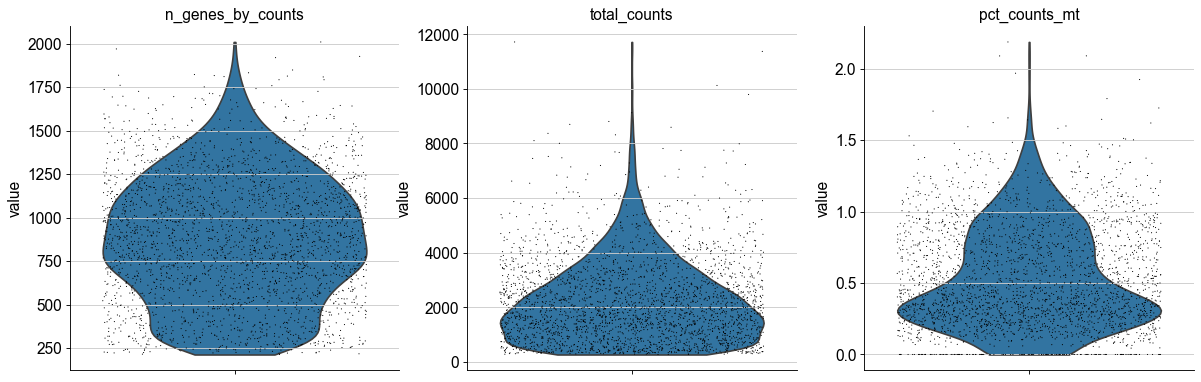

In [9]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

Last violin plot reveals mitochondrial genes present in reads. Can filter data to remove reads with a higher `pct_counts_mt` relative to the rest of the data. It is sometimes easier to see outliers if we plot our QC metrics against each other. This helps us identify and filter out low quality cells more clearly.

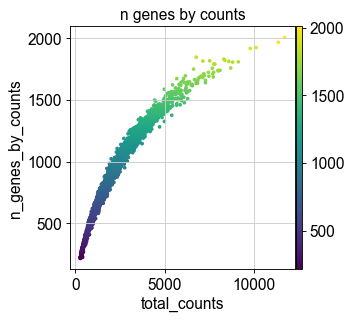

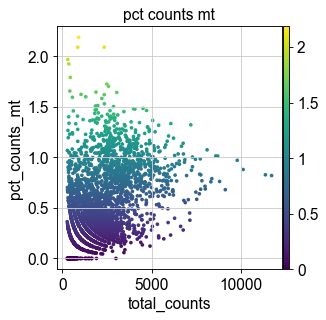

In [10]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color = 'n_genes_by_counts')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color = 'pct_counts_mt')

In the scatter plots we can see where the majority of our cells are lie in terms of percent of mitochondrial genes as well as total number of counts. From this we can determine that low quality cells are those that have a read count greater than 10000 or a mitochondrial gene percentage greater than 1.5

In [11]:
# Filter the adata based on the scatter plot results
# Create a copy of our data in order to compare our results after filtering 
bdata = adata.copy()
bdata = bdata[bdata.obs['total_counts'] < 10000, : ]
bdata = bdata[bdata.obs['pct_counts_mt'] < 1.5, :]

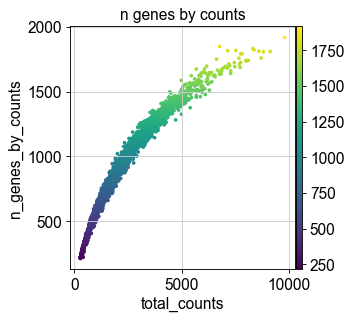

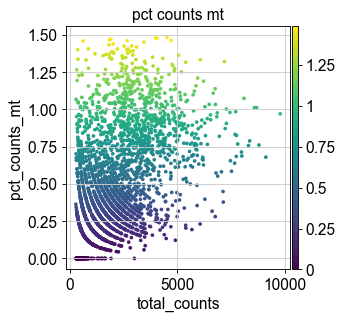

In [12]:
sc.pl.scatter(bdata, x='total_counts', y='n_genes_by_counts', color = 'n_genes_by_counts')
sc.pl.scatter(bdata, x='total_counts', y='pct_counts_mt', color = 'pct_counts_mt')

/Users/VictorMagdaleno/opt/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
normalizing counts per cell
    finished (0:00:00)


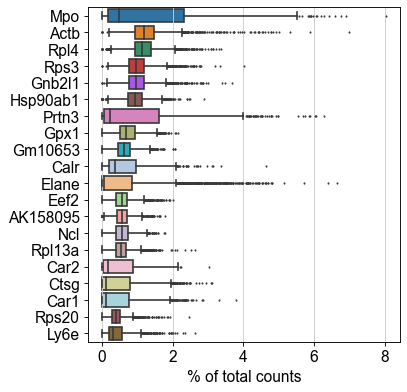

In [13]:
# Plot the top 20 highest expressed genes from the filtered data
sc.pl.highest_expr_genes(bdata, n_top= 20, )

## Data Normalization and Highly Variable Genes

Next I will normalize and logarithmize the data to get rid of any technical vaiation. We will be normalize the count to 10000 reads per cell. Once the data has been normalized, a log(n+1) transformation is applied to the data. 

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


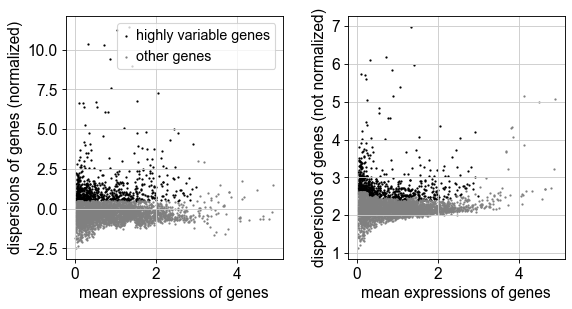

In [14]:
# Prepare data to find highly variable genes
# Again, create a copy of our data before normalizing 
norm_data = bdata.copy()
sc.pp.normalize_total(norm_data, target_sum=1e4)
sc.pp.log1p(norm_data)

# Plot highly variable genes
sc.pp.highly_variable_genes(norm_data, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(norm_data)

Subselect data to only include highly variable genes.

In [15]:
hvg_data = norm_data.copy()
hvg_data.raw = hvg_data
hvg_data = hvg_data[:, hvg_data.var.highly_variable]
hvg_data.to_df().head()

,1100001G20Rik,1110013L07Rik,1190002H23Rik,1500012F01Rik,2010002N04Rik,2210020M01Rik,2310014H01Rik,2410006H16Rik,2610035D17Rik,4930473A06Rik,...,Zcchc11,Zfhx3,Zfp579,Zfp945,Zfpm1,Zswim4,Zyx,mKIAA0569,mKIAA1575,slc43a2
0,0.0,0.000000,0.000000,3.378564,0.0,3.378564,0.0,0.000000,0.0,0.000000,...,0.00000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
1,0.0,0.000000,1.591755,0.000000,0.0,0.000000,0.0,1.591755,0.0,0.000000,...,0.00000,0.00000,0.0,0.0,0.000000,0.0,0.0,2.177557,0.000000,0.0
2,0.0,0.000000,0.000000,0.000000,0.0,1.147720,0.0,1.668084,0.0,1.147720,...,1.14772,1.14772,0.0,0.0,2.776145,0.0,0.0,1.668084,1.147720,0.0
3,0.0,1.172221,2.294213,2.039592,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.00000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
4,0.0,0.000000,1.577423,1.911568,0.0,0.000000,0.0,1.911568,0.0,1.577423,...,0.00000,0.00000,0.0,0.0,2.527916,0.0,0.0,0.000000,1.577423,0.0


## Dimensionality Reduction 

PCA will be performed on the highly varibale genes.




In [16]:
hvPCA = hvg_data.copy()
# Scales down the down to unit variance and mean zero for PCA 
sc.pp.scale(hvPCA, max_value = 10)
# Reduce Dimensionality of our Data using PCA
sc.tl.pca(hvPCA, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:04)


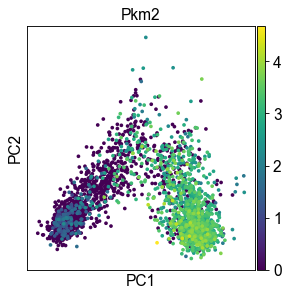

In [17]:
sc.pl.pca(hvPCA, color = "Pkm2")

/Users/VictorMagdaleno/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/VictorMagdaleno/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0, flags=flags)


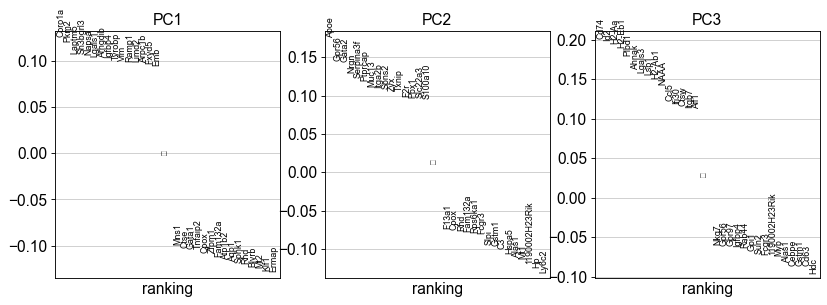

In [18]:
sc.pl.pca_loadings(hvPCA)

Now that we have the PC projections of the highly variable genes, we can see how that compares to ALL GENES. We'll apply the same set of transformationto the normalized data that we saved earlier and see if it is vastly different.

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)


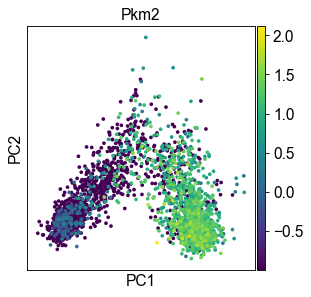

In [19]:
sc.pp.scale(norm_data, max_value = 10)
sc.tl.pca(norm_data, svd_solver='arpack')
sc.pl.pca(norm_data, color = "Pkm2")

/Users/VictorMagdaleno/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/VictorMagdaleno/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0, flags=flags)


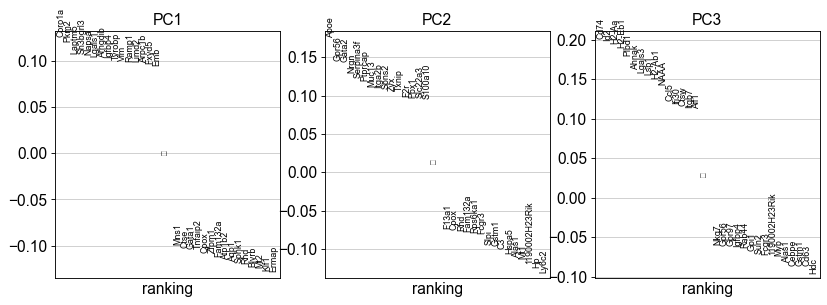

In [20]:
sc.pl.pca_loadings(norm_data)

We can see that the highly variable gene, **Pkm2**, does not drastically change the shape of our raw data PC projections, at least with respect to our first two principle components.

In [21]:
#sc.pp.neighbors(hvg_data, n_neighbors=10, n_pcs=40)

In [22]:
#sc.tl.umap(hvg_data)

In [23]:
#sc.tl.leiden(hvg_data, key_added = 'clusters')

In [24]:
#sc.pl.umap(hvg_data, color= ['clusters', 'n_genes_by_counts', 'total_counts'])

Seem to have found two unique subpopulations in clusters 7 and 8.

Now that the data is filtered to only contain data from the highly variable genes, I can plot the highest expressed genes and then replot the clusters with respect to the highest expressed genes.

In [25]:
#sc.pl.highest_expr_genes(hvg_data, n_top= 20, )

In [26]:
#sc.pl.umap(hvg_data, color= ['clusters', 'H2-D1', 'Prdx2', 'Laptm5', 
#                            'Cst3', 'Chd4', 'Mt1', 'Hspa5', 'Arhgdib'])

In [27]:
#sc.tl.rank_genes_groups(hvg_data, 'clusters', method='t-test')
#sc.pl.rank_genes_groups(hvg_data, n_genes=25, sharey=False)

In [28]:
#sc.tl.rank_genes_groups(hvg_data, groupby='clusters', method='wilcoxon')

In [29]:
#sc.pl.rank_genes_groups_dotplot(hvg_data, n_genes=4, values_to_plot='logfoldchanges', min_logfoldchange=3, vmax=7, vmin=-7, cmap='bwr')